In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

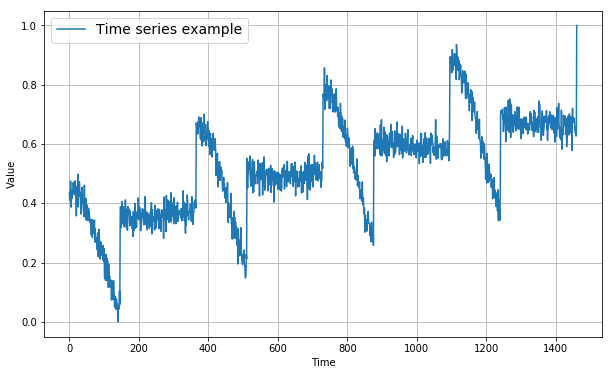

In [8]:
# Define the time series
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * (np.sqrt(time))

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

# The time series
time = np.arange(4 * 365 + 1)
baseline = 10
series = baseline + trend(time,0.5) + white_noise(time, noise_level=1, seed=0) + seasonality(time, period=365, amplitude=10, phase=0)
# Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(series.reshape(-1,1))
series = scaler.transform(series.reshape(-1,1))[0:,0]
# Plot
plt.figure(figsize=(10, 6))
plot_series(time, series, label='Time series example')
plt.show()

In [9]:
def seq2seq_window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
# Train and validation split
x_train = time[:1000]
y_train = series[:1000]
x_val = time[1000:]
y_val = series[1000:]
# Train and val sets
window_size = 30
train_set = seq2seq_window_dataset(y_train, window_size=30, batch_size=128) 
val_set = seq2seq_window_dataset(y_val, window_size=30, batch_size=128)

In [11]:
# Model fitting: recurrent sequence-to-sequence model
model =  tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(units=100, return_sequences=True,
                             input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(units=100, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])
model.compile(loss=tf.keras.losses.Huber(),
             optimizer='adam',
             metrics=['mae'])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "seq2seq_checkpoint.h5", save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)

model.fit(train_set, epochs=200, validation_data=val_set,callbacks=[early_stopping, model_checkpoint])

Epoch 1/200
8/8 [==============================] - 5s 606ms/step - loss: 0.1038 - mae: 0.3609 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/200
8/8 [==============================] - 1s 122ms/step - loss: 0.0205 - mae: 0.1590 - val_loss: 0.0427 - val_mae: 0.2688
Epoch 3/200
8/8 [==============================] - 1s 122ms/step - loss: 0.0108 - mae: 0.1089 - val_loss: 0.0068 - val_mae: 0.0797
Epoch 4/200
8/8 [==============================] - 1s 120ms/step - loss: 0.0048 - mae: 0.0723 - val_loss: 0.0044 - val_mae: 0.0617
Epoch 5/200
8/8 [==============================] - 1s 127ms/step - loss: 0.0036 - mae: 0.0611 - val_loss: 0.0042 - val_mae: 0.0655
Epoch 6/200
8/8 [==============================] - 1s 122ms/step - loss: 0.0023 - mae: 0.0480 - val_loss: 0.0038 - val_mae: 0.0643
Epoch 7/200
8/8 [==============================] - 1s 123ms/step - loss: 0.0018 - mae: 0.0419 - val_loss: 0.0026 - val_mae: 0.0500
Epoch 8/200
8/8 [==============================] - 1s 125ms/step - loss: 0.

In [12]:
model = tf.keras.models.load_model("seq2seq_checkpoint.h5")

0.0019327498


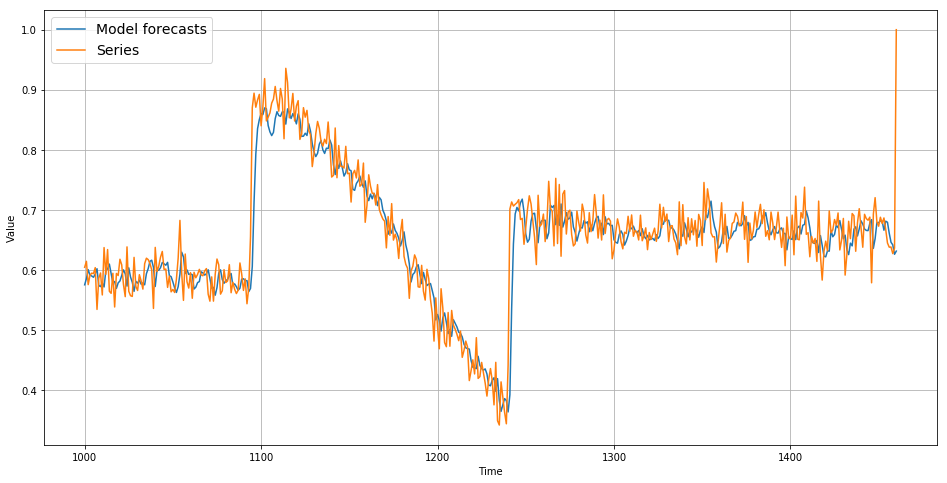

In [13]:
forecasts = model_forecast(model, series[..., np.newaxis], window_size = window_size)[1000-window_size:-1,-1, 0]
plt.figure(figsize=(16,8))
plot_series(x_val, forecasts, label='Model forecasts')
plot_series(x_val, y_val, label='Series')
print(tf.keras.metrics.mean_squared_error(y_val, forecasts).numpy())

1096
-0.05186383322739552
0.31137242156446
0.3632362547918555


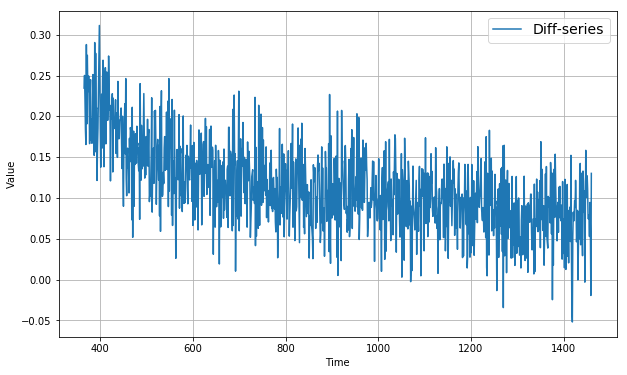

In [14]:
# Differencing
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]
diff_x_val = diff_time[1000:]

plt.figure(figsize=(10,6))
plot_series(diff_time, diff_series, label='Diff-series')
print(len(diff_series))

# Train and validation split for diff data
diff_y_train = diff_series[:1000-365]
diff_y_val = diff_series[1000-365:]
# Train and val sets
window_size = 30
diff_train_set = seq2seq_window_dataset(diff_y_train, window_size=30, batch_size=128) 
diff_val_set = seq2seq_window_dataset(diff_y_val, window_size=30, batch_size=128)
print(diff_series.min())
print(diff_series.max())
scale = diff_series.max()-diff_series.min()
print(scale)

In [15]:
# Train model on differenced data
model2 =  tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(units=100, return_sequences=True,
                             input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(units=100, return_sequences=True),
    tf.keras.layers.SimpleRNN(units=100, return_sequences=True),
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(units=1)
])
model2.compile(loss=tf.keras.losses.Huber(),
             optimizer='adam',
             metrics=['mae'])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "seq2seq_checkpoint.h5", save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)

model2.fit(diff_train_set, epochs=200, validation_data=diff_val_set,callbacks=[early_stopping, model_checkpoint])

Epoch 1/200
5/5 [==============================] - 6s 1s/step - loss: 0.0950 - mae: 0.2905 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/200
5/5 [==============================] - 1s 194ms/step - loss: 0.0089 - mae: 0.1074 - val_loss: 0.0088 - val_mae: 0.1084
Epoch 3/200
5/5 [==============================] - 1s 201ms/step - loss: 0.0049 - mae: 0.0764 - val_loss: 0.0047 - val_mae: 0.0789
Epoch 4/200
5/5 [==============================] - 1s 233ms/step - loss: 0.0031 - mae: 0.0606 - val_loss: 0.0032 - val_mae: 0.0648
Epoch 5/200
5/5 [==============================] - 1s 221ms/step - loss: 0.0022 - mae: 0.0515 - val_loss: 0.0026 - val_mae: 0.0577
Epoch 6/200
5/5 [==============================] - 1s 222ms/step - loss: 0.0018 - mae: 0.0469 - val_loss: 0.0020 - val_mae: 0.0507
Epoch 7/200
5/5 [==============================] - 1s 212ms/step - loss: 0.0015 - mae: 0.0429 - val_loss: 0.0015 - val_mae: 0.0442
Epoch 8/200
5/5 [==============================] - 1s 202ms/step - loss: 0.001

In [16]:
model2 = tf.keras.models.load_model("seq2seq_checkpoint.h5")

0.0016869053


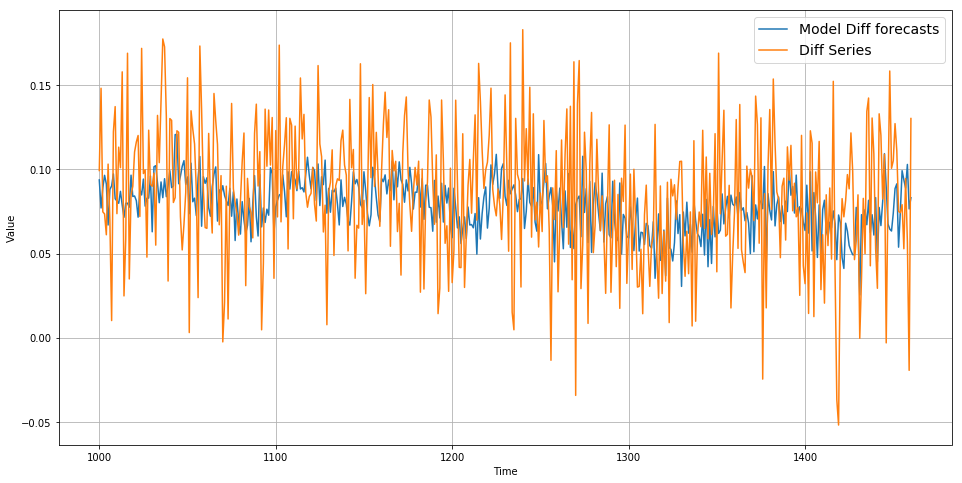

In [17]:
diff_forecasts = model_forecast(model2, diff_series[..., np.newaxis], window_size = window_size)[1000-365-window_size:-1,-1, 0]
plt.figure(figsize=(16,8))
plot_series(x_val, diff_forecasts, label='Model Diff forecasts')
plot_series(x_val, diff_y_val, label='Diff Series')
print(tf.keras.metrics.mean_squared_error(diff_y_val, diff_forecasts).numpy())

0.0016869055451146607


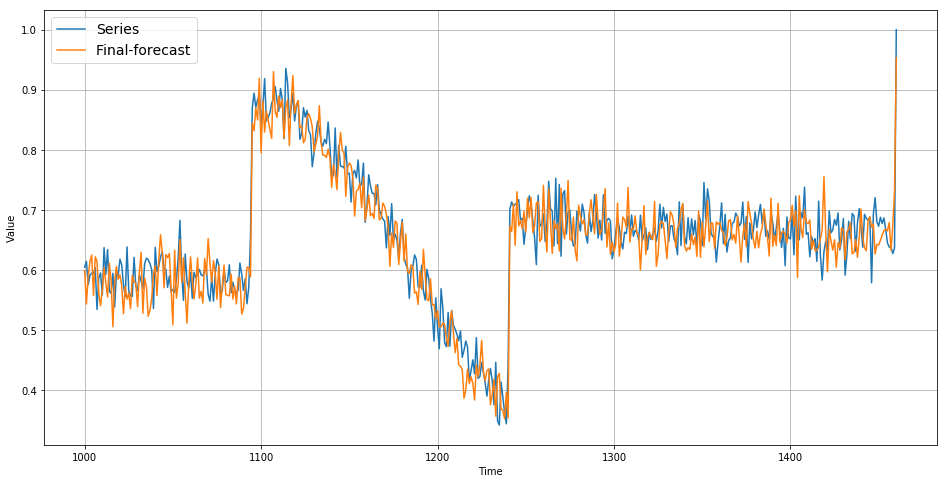

In [18]:
# De-differencing
final_diff_forecast = diff_forecasts + series[1000-365:1000-365+len(y_val)]
plt.figure(figsize=(16, 8))
plot_series(x_val, y_val, label="Series")
plot_series(x_val, final_diff_forecast, label="Final-forecast")
print(tf.keras.metrics.mean_squared_error(y_val, final_diff_forecast).numpy())